# Install Package

In [1]:
%pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00


# Import Libraries

In [11]:
from datasets import load_dataset,DatasetDict
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load Dataset

In [31]:
import pandas as pd

pandas_df = pd.read_parquet("hf://datasets/tdavidson/hate_speech_offensive/data/train-00000-of-00001.parquet")

In [32]:
pandas_df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [35]:
pandas_df['class']

,class
0,2
1,1
2,1
3,1
4,1
...,...
24778,1
24779,2
24780,1
24781,1


<Axes: xlabel='class', ylabel='count'>

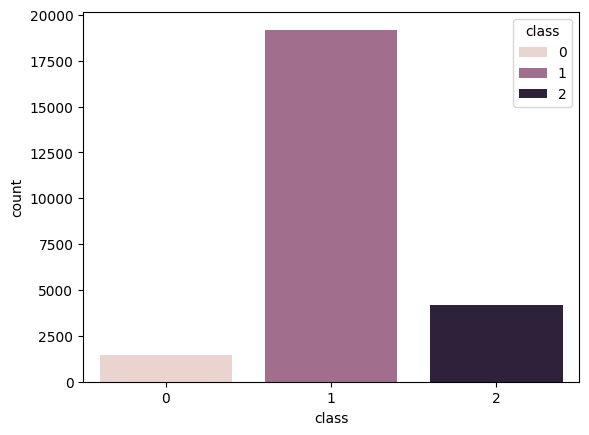

In [38]:
import seaborn as sns
sns.countplot(x='class', data=pandas_df, hue='class')

## Clean Data

In [39]:
pandas_df['tweet_cleaned'] = pandas_df['tweet'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
pandas_df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,tweet_cleaned
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,!!! RT : As a woman you shouldn't complain abo...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,!!!!!!!!! RT _G_Anderson: _based she look like...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,!!!!!!!!!!!!! RT : The shit you hear about me ...


In [40]:
from datasets import Dataset

ds = Dataset.from_pandas(pandas_df)
ds

Dataset({
    features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet', 'tweet_cleaned'],
    num_rows: 24783
})

In [44]:
train_test_valid = ds.train_test_split()

test_valid = train_test_valid['test'].train_test_split()

train_test_valid_dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
    })


dataset = train_test_valid_dataset.remove_columns(['hate_speech_count', 'offensive_language_count', 'neither_count', 'count'])
dataset

DatasetDict({
    train: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 18587
    })
    test: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 1549
    })
    valid: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 4647
    })
})

# Tokenizer

## load tokenizer

In [47]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Test tokenizer

In [48]:
text = "Just checking tokenization"

output = tokenizer(text)

output

{'input_ids': [101, 2066, 9444, 22559, 2734, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [49]:
tokens = tokenizer.convert_ids_to_tokens(output['input_ids'])
tokens

['[CLS]', 'Just', 'checking', 'token', '##ization', '[SEP]']

In [50]:
print(f"Tokenized text: {tokenizer.convert_tokens_to_string(tokens)}")

Tokenized text: [CLS] Just checking tokenization [SEP]


In [51]:
print(f"Vocab size is : {tokenizer.vocab_size}")

print(f"Model max length is : {tokenizer.model_max_length}")

print(f"Model input names are: {tokenizer.model_input_names}")

Vocab size is : 28996
Model max length is : 512
Model input names are: ['input_ids', 'token_type_ids', 'attention_mask']


## Tokenize Function

In [53]:
def tokenize_function(train_dataset):
    return tokenizer(train_dataset['tweet_cleaned'], padding='max_length', truncation=True)


tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenized_dataset

Map:   0%|          | 0/18587 [00:00<?, ? examples/s]

Map:   0%|          | 0/1549 [00:00<?, ? examples/s]

Map:   0%|          | 0/4647 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 18587
    })
    test: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1549
    })
    valid: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4647
    })
})

## Tokenize Dataset

In [56]:

train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['valid']
test_dataset = tokenized_dataset['test']

train_dataset

Dataset({
    features: ['class', 'tweet', 'tweet_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 18587
})

In [57]:
train_set = train_dataset.remove_columns(['tweet', "tweet_cleaned"]).with_format('tensorflow')

tf_eval_dataset = eval_dataset.remove_columns(['tweet', "tweet_cleaned"]).with_format('tensorflow')

tf_test_dataset = test_dataset.remove_columns(['tweet', "tweet_cleaned"]).with_format('tensorflow')

In [58]:
train_features = { x: train_set[x] for x in tokenizer.model_input_names  }

train_set_for_final_model = tf.data.Dataset.from_tensor_slices((train_features, train_set['class'] ))

train_set_for_final_model = train_set_for_final_model.shuffle(len(train_set)).batch(8)

In [59]:
eval_features = {x: tf_eval_dataset[x] for x in tokenizer.model_input_names}
val_set_for_final_model = tf.data.Dataset.from_tensor_slices((eval_features, tf_eval_dataset["class"]))
val_set_for_final_model = val_set_for_final_model.batch(8)

test_features = {x: tf_test_dataset[x] for x in tokenizer.model_input_names}
test_set_for_final_model = tf.data.Dataset.from_tensor_slices((test_features, tf_test_dataset["class"]))
test_set_for_final_model =test_set_for_final_model.batch(8)

# Load and compile Model

In [60]:
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training Model

In [61]:
history = model.fit(train_set_for_final_model,
                    validation_data=val_set_for_final_model,
                    epochs=3 )

Epoch 1/3
2324/2324 [==============================] - 2375s 987ms/step - loss: 0.3284 - sparse_categorical_accuracy: 0.8872 - val_loss: 0.2884 - val_sparse_categorical_accuracy: 0.9055
Epoch 2/3
2324/2324 [==============================] - 2296s 988ms/step - loss: 0.2852 - sparse_categorical_accuracy: 0.9021 - val_loss: 0.2592 - val_sparse_categorical_accuracy: 0.9109
Epoch 3/3
2324/2324 [==============================] - 2290s 985ms/step - loss: 0.2575 - sparse_categorical_accuracy: 0.9106 - val_loss: 0.2606 - val_sparse_categorical_accuracy: 0.9094


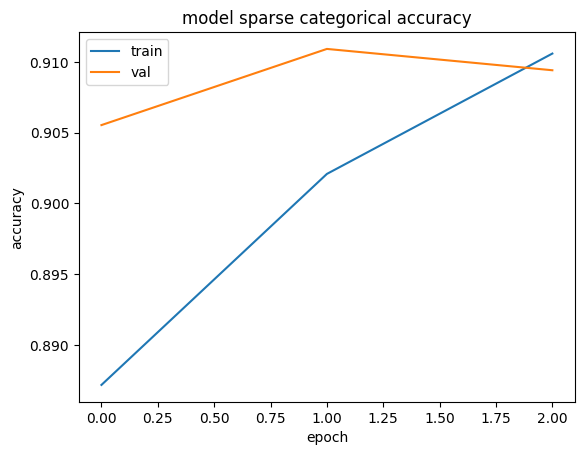

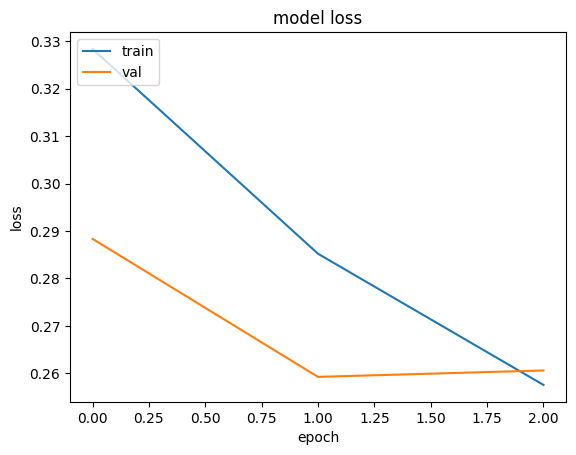

In [62]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model sparse categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluate Model

In [63]:
test_loss, test_acc = model.evaluate(test_set_for_final_model,verbose=2)
print('\nTest accuracy:', test_acc)

194/194 - 63s - loss: 0.2516 - sparse_categorical_accuracy: 0.9116 - 63s/epoch - 325ms/step

Test accuracy: 0.911555826663971


# Predict Bert Model

In [65]:
predict_score_and_class_dict = {0: 'Hate Speech',
 1: 'Offensive Language',
 2: 'Neither'}

preds = model(tokenizer(["He is useless, I dont know why he came to our neighbourhood", "That guy sucks", "He is such a retard"],return_tensors="tf",padding=True,truncation=True))['logits']

print(preds)

class_preds = np.argmax(preds, axis=1)

for pred in class_preds:
  print(predict_score_and_class_dict[pred])

tf.Tensor(
[[-1.354622    0.49887672  0.855539  ]
 [-1.669037    0.07300647  1.7006899 ]
 [-0.24571076  2.3914983  -2.441549  ]], shape=(3, 3), dtype=float32)
Neither
Neither
Offensive Language


In [66]:
predict_score_and_class_dict = {0: 'Hate Speech',
 1: 'Offensive Language',
 2: 'Neither'}
preds = model(tokenizer(["He dresses up like a begger thise days"],return_tensors="tf",padding=True,truncation=True))['logits']
print(preds)
class_preds = np.argmax(preds, axis=1)

for pred in class_preds:
  print(predict_score_and_class_dict[pred])

tf.Tensor([[-1.5158917  0.4804067  1.0637728]], shape=(1, 3), dtype=float32)
Neither
